In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# ### --- Cell 1: Fix Kaggle Environment --- ###
# This MUST be run first in Kaggle to fix a protobuf version issue
# It will show a lot of "incompatible" warnings, which is NORMAL and can be ignored.
# Note: You must have Internet turned ON in your notebook settings for this to work.
print("Installing correct protobuf version...")
import os
os.system('pip install protobuf==3.20.*')
print("✅ Protobuf fix applied.")


Installing correct protobuf version...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
✅ Protobuf fix applied.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires p

In [3]:
# ### --- Cell 2: All Imports --- ###
# Import all necessary libraries for the project.
print("\nImporting libraries...")
import pandas as pd
import numpy as np
import librosa
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow / Keras Imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, 
    Reshape, LSTM, Dense, Layer
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
print("✅ Libraries imported.")


Importing libraries...


2025-11-14 06:02:52.884502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763100173.079820      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763100173.133708      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Libraries imported.


In [4]:
# ### --- Cell 3: Custom Attention Layer --- ###
# Define the custom AttentionLayer class that will be used in our most advanced model.
print("\nDefining AttentionLayer class...")
class AttentionLayer(Layer):
    """
    Custom Keras Attention Layer for sequence models.
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                shape=(input_shape[-1], input_shape[-1]),
                                initializer='glorot_uniform',
                                trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                shape=(input_shape[-1],),
                                initializer='zeros',
                                trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

print("✅ AttentionLayer class defined.")


Defining AttentionLayer class...
✅ AttentionLayer class defined.


In [5]:
# ### --- Cell 4: Data Preparation Functions --- ###
# Define the core functions to parse the dataset, extract features (with augmentation),
# and build the initial DataFrame.
print("\nDefining data preparation functions...")

def create_dataset_dataframe(dataset_path):
    """
    Parses the RAVDESS dataset filenames to create a structured DataFrame.
    """
    emotion_map = {
        "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
        "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
    }
    data = []
    print(f"Parsing dataset from: {dataset_path}")
    
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset path does not exist: {dataset_path}")
        return None

    for actor_folder in sorted(os.listdir(dataset_path)):
        actor_path = os.path.join(dataset_path, actor_folder)
        if os.path.isdir(actor_path):
            for file_name in os.listdir(actor_path):
                if file_name.endswith(".wav"):
                    parts = file_name.split(".")[0].split("-")
                    if len(parts) == 7:
                        emotion_code = parts[2]
                        actor_id = parts[6]
                        file_path = os.path.join(actor_path, file_name)
                        emotion_label = emotion_map.get(emotion_code)
                        if emotion_label:
                            data.append({
                                "filepath": file_path,
                                "actor": actor_id,
                                "emotion": emotion_label
                            })
    
    if not data:
        print("\nError: No data was loaded. Please check the dataset path.")
        return None
        
    df = pd.DataFrame(data)
    print(f"\n✅ Successfully created DataFrame with {len(df)} entries.")
    return df

def extract_features(file_path, augment=False):
    """
    Extracts Mel Spectrogram from an audio file and optionally applies augmentation.
    *** Includes aggressive augmentation: Noise, Time Shift, Pitch Shift, Time Stretch. ***
    """
    try:
        signal, sample_rate = librosa.load(file_path, sr=22050)
        
        if augment:
            # 1. Noise Injection
            noise_amp = 0.005 * np.random.uniform() * np.amax(signal)
            signal = signal + noise_amp * np.random.normal(size=signal.shape[0])
            
            # 2. Time Shifting
            shift_range = int(np.random.uniform(low=-5, high=5) * (sample_rate / 1000)) # +/- 5ms shift
            signal = np.roll(signal, shift_range)
            
            # 3. Pitch Shifting
            pitch_shift = np.random.uniform(low=-1, high=1) # Shift up or down by 1 semitone
            signal = librosa.effects.pitch_shift(y=signal, sr=sample_rate, n_steps=pitch_shift)
            
            # 4. Time Stretching
            stretch_rate = np.random.uniform(low=0.9, high=1.1) # Speed up or slow down by 10%
            signal = librosa.effects.time_stretch(y=signal, rate=stretch_rate)
        
        # Extract Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=128)
        
        return mel_spectrogram

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def build_feature_dataframe(dataset_path):
    """
    Creates the main DataFrame and extracts features for all files.
    """
    ravdess_df = create_dataset_dataframe(dataset_path)
    if ravdess_df is None:
        return None

    print("\nExtracting features from audio files... (This may take a few minutes)")
    
    # We will apply augmentation later, only to the training split
    tqdm.pandas(desc="Extracting Features")
    ravdess_df['mel_spectrogram'] = ravdess_df['filepath'].progress_apply(
        lambda filepath: extract_features(filepath, augment=False)
    )
    
    ravdess_df.dropna(inplace=True)
    print("\n✅ Feature extraction complete.")
    return ravdess_df

print("✅ Data preparation functions defined.")


Defining data preparation functions...
✅ Data preparation functions defined.


In [6]:
# ### --- Cell 5: Model Building Functions --- ###
# Define the functions that build our three different model architectures.
print("\nDefining model building functions...")

def build_cnn_model(input_shape, num_classes):
    """
    Builds the original, more powerful 2D CNN model with stronger Dropout.
    """
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x) # Increased dropout
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x) # Increased dropout
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x) # Increased dropout
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x) # Strong dropout
    
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_cnn_lstm_model(input_shape, num_classes):
    """
    Builds the original, more powerful CNN-LSTM model with stronger Dropout.
    """
    input_layer = Input(shape=input_shape)

    # Conv Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Reshape for LSTM
    conv_output_shape = x.shape[1:]
    new_shape = (conv_output_shape[0] * conv_output_shape[1], conv_output_shape[2])
    x = Reshape(new_shape)(x)

    # LSTM layers
    x = LSTM(128, return_sequences=False, dropout=0.4)(x) # Strong dropout

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_cnn_lstm_attention_model(input_shape, num_classes):
    """
    Builds the original, more powerful CNN-LSTM with Attention model.
    """
    input_layer = Input(shape=input_shape)

    # Conv Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Reshape for LSTM
    conv_output_shape = x.shape[1:]
    new_shape = (conv_output_shape[0] * conv_output_shape[1], conv_output_shape[2])
    x = Reshape(new_shape)(x)

    # LSTM layers (must return sequences for Attention)
    x = LSTM(128, return_sequences=True, dropout=0.4)(x)

    # Attention Layer
    x = AttentionLayer()(x)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("✅ Model building functions defined.")


Defining model building functions...
✅ Model building functions defined.


In [7]:
# ### --- Cell 6: Training & Evaluation Function --- ###
# This helper function runs the complete training and evaluation pipeline for a single model.
print("\nDefining training/evaluation function...")

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name="Model"):
    """
    Trains and evaluates a single model, returning its history and test score.
    """
    
    # Define callbacks to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_accuracy', 
                                   patience=20, # Stop if no improvement for 20 epochs
                                   restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                  factor=0.2, 
                                  patience=5, # Reduce LR if no improvement for 5 epochs
                                  min_lr=0.00001)
    
    print(f"\n--- Starting Model Training: {model_name} ---")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200, # Set high, EarlyStopping will find the best one
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    print(f"\n--- Evaluating {model_name} on Test Set ---")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Generate classification report
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))
    
    return history, (test_loss, test_accuracy)

print("✅ Training/evaluation function defined.")


Defining training/evaluation function...
✅ Training/evaluation function defined.


In [8]:
# ### --- Cell 7: Main Execution Function --- ###
# This cell defines the main() function that runs the entire process.
print("\nDefining main() function...")

def main():
    # --- Configuration ---
    
    # !!! IMPORTANT !!!
    # UPDATE THIS PATH to your dataset location
    DATASET_PATH = "/kaggle/input/ravdess-audio-only/DATASET" # This is the corrected path
    
    MAX_PAD_LEN = 174 # Standard padding length (based on 95th percentile)
    AUGMENTATION_FACTOR = 2 # 1 original + 2 augmented copies = 3x training data
    
    # --- 1. Load and Extract Features ---
    # This is the most time-consuming step
    df = build_feature_dataframe(DATASET_PATH)
    if df is None:
        print("Stopping execution due to data loading error.")
        return

    # --- 2. Prepare Data for Model ---
    
    def pad_spectrogram(spec, max_len):
        """Pads or truncates a spectrogram to a max length."""
        if spec.shape[1] > max_len:
            # Truncate
            return spec[:, :max_len]
        else:
            # Pad
            padding = max_len - spec.shape[1]
            return np.pad(spec, ((0, 0), (0, padding)), mode='constant')

    X_padded = np.array([pad_spectrogram(s, MAX_PAD_LEN) for s in df['mel_spectrogram'].tolist()])
    X_reshaped = X_padded[..., np.newaxis] # Add channel dimension
    
    global label_encoder # Make encoder globally accessible for reports
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(df['emotion'])
    num_classes = len(label_encoder.classes_)
    
    print(f"\nData prepared: X shape={X_reshaped.shape}, y shape={y_encoded.shape}")

    # --- 3. Actor-Independent Split (The CORRECT way) ---
    actor_ids = df['actor'].unique()
    train_actors, test_actors = train_test_split(actor_ids, test_size=0.15, random_state=42)
    train_actors, val_actors = train_test_split(train_actors, test_size=(0.15/0.85), random_state=42) # ~17.6% of 85%

    train_indices = df['actor'].isin(train_actors)
    val_indices = df['actor'].isin(val_actors)
    test_indices = df['actor'].isin(test_actors)

    # Create base splits (non-augmented)
    X_train_base, y_train_base = X_reshaped[train_indices], y_encoded[train_indices]
    X_val, y_val = X_reshaped[val_indices], y_encoded[val_indices]
    X_test, y_test = X_reshaped[test_indices], y_encoded[test_indices]
    
    print("\n--- Data Split Summary (Actor-Independent) ---")
    print(f"Base Training set: {X_train_base.shape} samples ({len(train_actors)} actors)")
    print(f"Validation set:    {X_val.shape} samples ({len(val_actors)} actors)")
    print(f"Test set:          {X_test.shape} samples ({len(test_actors)} actors)")

    # --- 4. Data Augmentation for Training Set ---
    # We re-extract features for the training set *with* augmentation
    print("\nApplying augmentation to the training set...")
    X_train_augmented = []
    y_train_augmented = []
    
    train_df = df[train_indices]
    
    for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Augmenting"):
        # 1. Add the Original
        X_train_augmented.append(pad_spectrogram(row['mel_spectrogram'], MAX_PAD_LEN))
        y_train_augmented.append(row['emotion'])
        
        # 2. Add augmented copies
        for _ in range(AUGMENTATION_FACTOR):
            aug_spec = extract_features(row['filepath'], augment=True)
            if aug_spec is not None:
                X_train_augmented.append(pad_spectrogram(aug_spec, MAX_PAD_LEN))
                y_train_augmented.append(row['emotion'])
            
    X_train = np.array(X_train_augmented)[..., np.newaxis]
    y_train = label_encoder.transform(y_train_augmented)
    
    print(f"Augmented training set shape: {X_train.shape}")
    
    # --- 5. Build, Train, and Evaluate All Models ---
    
    # Storage for results
    histories = {}
    scores = {}

    # Define input shape
    input_shape = X_train.shape[1:]

    # --- Model 1: CNN ---
    print("\n" + "="*50)
    print("--- MODEL 1: CNN ---")
    print("="*50)
    model_cnn = build_cnn_model(input_shape, num_classes)
    model_cnn.summary()
    hist_cnn, score_cnn = train_and_evaluate_model(
        model_cnn, X_train, y_train, X_val, y_val, X_test, y_test, "CNN"
    )
    histories['CNN'] = hist_cnn
    scores['CNN'] = score_cnn

    # --- Model 2: CNN-LSTM ---
    print("\n" + "="*50)
    print("--- MODEL 2: CNN-LSTM ---")
    print("="*50)
    model_cnn_lstm = build_cnn_lstm_model(input_shape, num_classes)
    model_cnn_lstm.summary()
    hist_cnn_lstm, score_cnn_lstm = train_and_evaluate_model(
        model_cnn_lstm, X_train, y_train, X_val, y_val, X_test, y_test, "CNN-LSTM"
    )
    histories['CNN-LSTM'] = hist_cnn_lstm
    scores['CNN-LSTM'] = score_cnn_lstm

    # --- Model 3: CNN-LSTM-Attention ---
    print("\n" + "="*50)
    print("--- MODEL 3: CNN-LSTM-Attention ---")
    print("="*50)
    model_cnn_lstm_att = build_cnn_lstm_attention_model(input_shape, num_classes)
    model_cnn_lstm_att.summary()
    hist_cnn_lstm_att, score_cnn_lstm_att = train_and_evaluate_model(
        model_cnn_lstm_att, X_train, y_train, X_val, y_val, X_test, y_test, "CNN-LSTM-Attention"
    )
    histories['CNN-LSTM-Attention'] = hist_cnn_lstm_att
    scores['CNN-LSTM-Attention'] = score_cnn_lstm_att
    
    # --- 6. Final Comparison ---
    print("\n" + "="*50)
    print("--- FINAL MODEL COMPARISON ---")
    print("="*50)
    
    results_df = pd.DataFrame({
        'Model': list(scores.keys()),
        'Test Loss': [s[0] for s in scores.values()],
        'Test Accuracy': [s[1] * 100 for s in scores.values()]
    }).sort_values(by='Test Accuracy', ascending=False)
    
    print(results_df.to_string(index=False, float_format="%.2f"))

    # Plot comparison of validation accuracy
    plt.figure(figsize=(12, 6))
    for model_name, history in histories.items():
        # Get the validation accuracy from the history object
        val_acc = history.history['val_accuracy']
        # Plot up to the point where training stopped
        plt.plot(val_acc, label=f'{model_name} Val Accuracy', alpha=0.8)
    
    plt.title('Model Validation Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

print("✅ main() function defined.")



Defining main() function...
✅ main() function defined.



--- Starting Main Execution ---
Parsing dataset from: /kaggle/input/ravdess-audio-only/DATASET

✅ Successfully created DataFrame with 1440 entries.

Extracting features from audio files... (This may take a few minutes)


Extracting Features: 100%|██████████| 1440/1440 [00:46<00:00, 30.67it/s]



✅ Feature extraction complete.

Data prepared: X shape=(1440, 128, 174, 1), y shape=(1440,)

--- Data Split Summary (Actor-Independent) ---
Base Training set: (960, 128, 174, 1) samples (16 actors)
Validation set:    (240, 128, 174, 1) samples (4 actors)
Test set:          (240, 128, 174, 1) samples (4 actors)

Applying augmentation to the training set...


Augmenting: 100%|██████████| 960/960 [02:48<00:00,  5.71it/s]


Augmented training set shape: (2880, 128, 174, 1)

--- MODEL 1: CNN ---


I0000 00:00:1763100660.989528      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 174, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 174, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,216 (430.53 KB)

 Trainable params: 110,216 (430.53 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training: CNN ---
Epoch 1/200


I0000 00:00:1763100665.775901     145 service.cc:148] XLA service 0x7da614025e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763100665.776547     145 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763100666.085408     145 cuda_dnn.cc:529] Loaded cuDNN version 90300


13/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1490 - loss: 2.0615

I0000 00:00:1763100670.563423     145 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.1825 - loss: 2.0066 - val_accuracy: 0.2333 - val_loss: 1.9803 - learning_rate: 0.0010
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2315 - loss: 1.9423 - val_accuracy: 0.2708 - val_loss: 1.9751 - learning_rate: 0.0010
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2336 - loss: 1.9066 - val_accuracy: 0.2542 - val_loss: 2.0152 - learning_rate: 0.0010
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2475 - loss: 1.8696 - val_accuracy: 0.2958 - val_loss: 1.9140 - learning_rate: 0.0010
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2675 - loss: 1.8221 - val_accuracy: 0.2083 - val_loss: 1.9430 - learning_rate: 0.0010
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2882 - loss: 1.8078 - val_accuracy: 0.2792 - val_loss: 1.9150 - learning_rate: 0.0010
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2943 - loss: 1.7977 - val_accurac

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 174, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 174, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1376, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,408 (493.78 KB)

 Trainable params: 126,408 (493.78 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training: CNN-LSTM ---
Epoch 1/200


E0000 00:00:1763100728.018809      48 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.1392 - loss: 2.0761 - val_accuracy: 0.1333 - val_loss: 2.0665 - learning_rate: 0.0010
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.1262 - loss: 2.0675 - val_accuracy: 0.1333 - val_loss: 2.0635 - learning_rate: 0.0010
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.1489 - loss: 2.0508 - val_accuracy: 0.1792 - val_loss: 2.0130 - learning_rate: 0.0010
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.1766 - loss: 2.0260 - val_accuracy: 0.2042 - val_loss: 1.9698 - learning_rate: 0.0010
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.1955 - loss: 1.9817 - val_accuracy: 0.2583 - val_loss: 1.9246 - learning_rate: 0.0010
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.2201 - loss: 1.9433 - val_accuracy: 0.2167 - val_loss: 1.9911 - learning_rate: 0.0010
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.2268 - loss: 1.9458 - val_accurac

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 174, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 174, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 336, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 336, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 128)            │        16,512 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,544 (974.78 KB)

 Trainable params: 249,544 (974.78 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training: CNN-LSTM-Attention ---
Epoch 1/200


E0000 00:00:1763100909.605142      48 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/dropout_7_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.1797 - loss: 1.9894 - val_accuracy: 0.2500 - val_loss: 1.8824 - learning_rate: 0.0010
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2650 - loss: 1.8426 - val_accuracy: 0.2375 - val_loss: 1.8899 - learning_rate: 0.0010
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2880 - loss: 1.8164 - val_accuracy: 0.2458 - val_loss: 1.9127 - learning_rate: 0.0010
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2862 - loss: 1.8169 - val_accuracy: 0.2458 - val_loss: 1.8933 - learning_rate: 0.0010
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3057 - loss: 1.7987 - val_accuracy: 0.2917 - val_loss: 1.8584 - learning_rate: 0.0010
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3028 - loss: 1.7839 - val_accuracy: 0.3417 - val_loss: 1.8307 - learning_rate: 0.0010
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2978 - loss: 1.7642 - val_accuracy

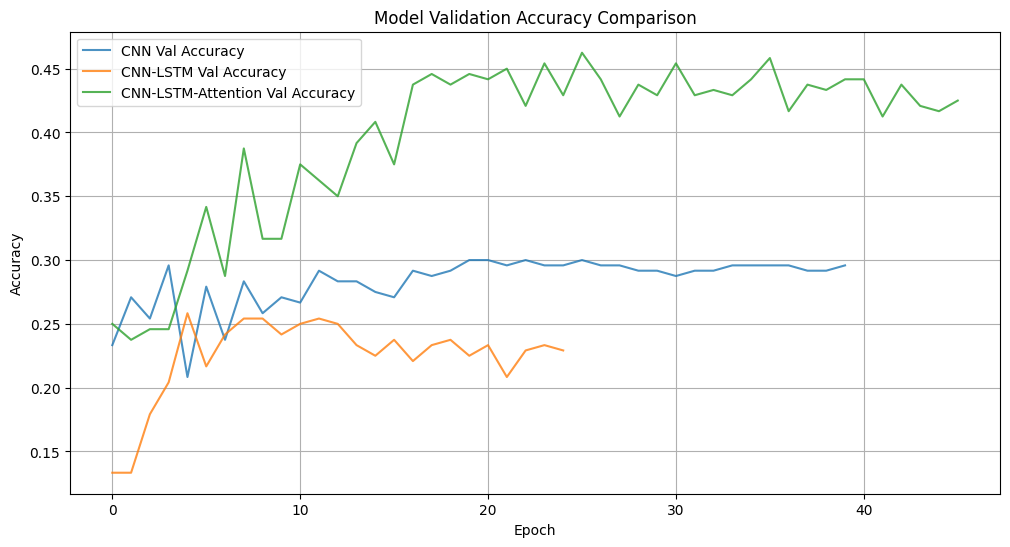


--- ✅ Script Complete ---


In [10]:
# ### --- Cell 8: Run Main Execution --- ###
# This is the final cell. Running this will start the entire process.
print("\n--- Starting Main Execution ---")
main()
print("\n--- ✅ Script Complete ---")